# **Data Science for Business - Group Project Part 2**

---
---

## 1.  **Work Environment Set Up** 
 
### Import :

In [1]:
# Define the model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Train the model 
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

#Preprocessing and utils import
from collections import defaultdict
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import logging
import shutil
import cv2
import os


# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow messages
logging.getLogger('tensorflow').setLevel(logging.FATAL)

# For Absl warnings (used in TensorFlow)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


Using the Labels.txt file, we have the labels for each image in the Character_Images folder. We begin by organizing all images into separate folders based on their labels. Simultaneously, we split the data into training and validation sets following the standard 80/20% proportion.

In [2]:
# Paths
image_folder = './Character_Images'
labels_file = './Labels.txt'
categorized_folder = './Categorized_Character_images'
train_folder = os.path.join(categorized_folder, 'train')
val_folder = os.path.join(categorized_folder, 'validation')

# Load labels and format them
labels_dict = {}
with open(labels_file, 'r') as file:
    for line in file:
        key, value = line.strip().split(',')
        formatted_filename = key.strip() + ".png"
        labels_dict[formatted_filename] = value.strip()

# Ensure folders exist for each class
label_classes = set(labels_dict.values())
for label_class in label_classes:
    os.makedirs(os.path.join(train_folder, label_class), exist_ok=True)
    os.makedirs(os.path.join(val_folder, label_class), exist_ok=True)

# Group filenames by label
files_by_label = defaultdict(list)
for filename, label in labels_dict.items():
    files_by_label[label].append(filename)

# Split files into train and validation ensuring 80/20 proportion for each label
train_files = []
val_files = []
for label, files in files_by_label.items():
    # Perform the split for each label
    train_split, val_split = train_test_split(files, test_size=0.2, random_state=42)
    # Organize train and validation files by label
    train_files.extend([(file, label) for file in train_split])
    val_files.extend([(file, label) for file in val_split])

# Function to copy files into categorized folders
def copy_files_to_categorized_folders(file_list, src_folder, dst_folder):
    for filename, label in file_list:
        src_path = os.path.join(src_folder, filename)
        dst_label_folder = os.path.join(dst_folder, label)
        dst_path = os.path.join(dst_label_folder, filename)
        if os.path.exists(src_path):
            shutil.copy2(src_path, dst_path)
        else:
            print(f"Warning: File not found: {src_path}")

# Organize files into train and validation folders
copy_files_to_categorized_folders(train_files, image_folder, train_folder)
copy_files_to_categorized_folders(val_files, image_folder, val_folder)

print("Files successfully organized into train and validation folders.")

# Verify the split
def count_files_by_label(folder):
    counts = {}
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            counts[label] = len(os.listdir(label_path))
    return counts

train_counts = count_files_by_label(train_folder)
val_counts = count_files_by_label(val_folder)

print("Train folder distribution:", train_counts)
print("Validation folder distribution:", val_counts)

Files successfully organized into train and validation folders.
Train folder distribution: {'9': 7509, '0': 7684, '7': 7509, '6': 7509, '1': 7509, '8': 7509, 'C': 7509, '4': 7509, 'X': 7509, '3': 7509, 'E': 7509, '2': 7509, '5': 15018}
Validation folder distribution: {'9': 652, '0': 1921, '7': 706, '6': 1668, '1': 1131, '8': 1764, 'C': 204, '4': 822, 'X': 223, '3': 926, 'E': 203, '2': 1018, '5': 3755}


An early observation reveals that the digit “5” is significantly overrepresented in the dataset. This class imbalance is crucial to address during model training to prevent the model from disproportionately favoring this class, which could negatively impact its overall performance and fairness.

---

## Data Observation:
Now that we have organized all the images, we can have a look at some of them to see if and what kind of data augmentation is needed

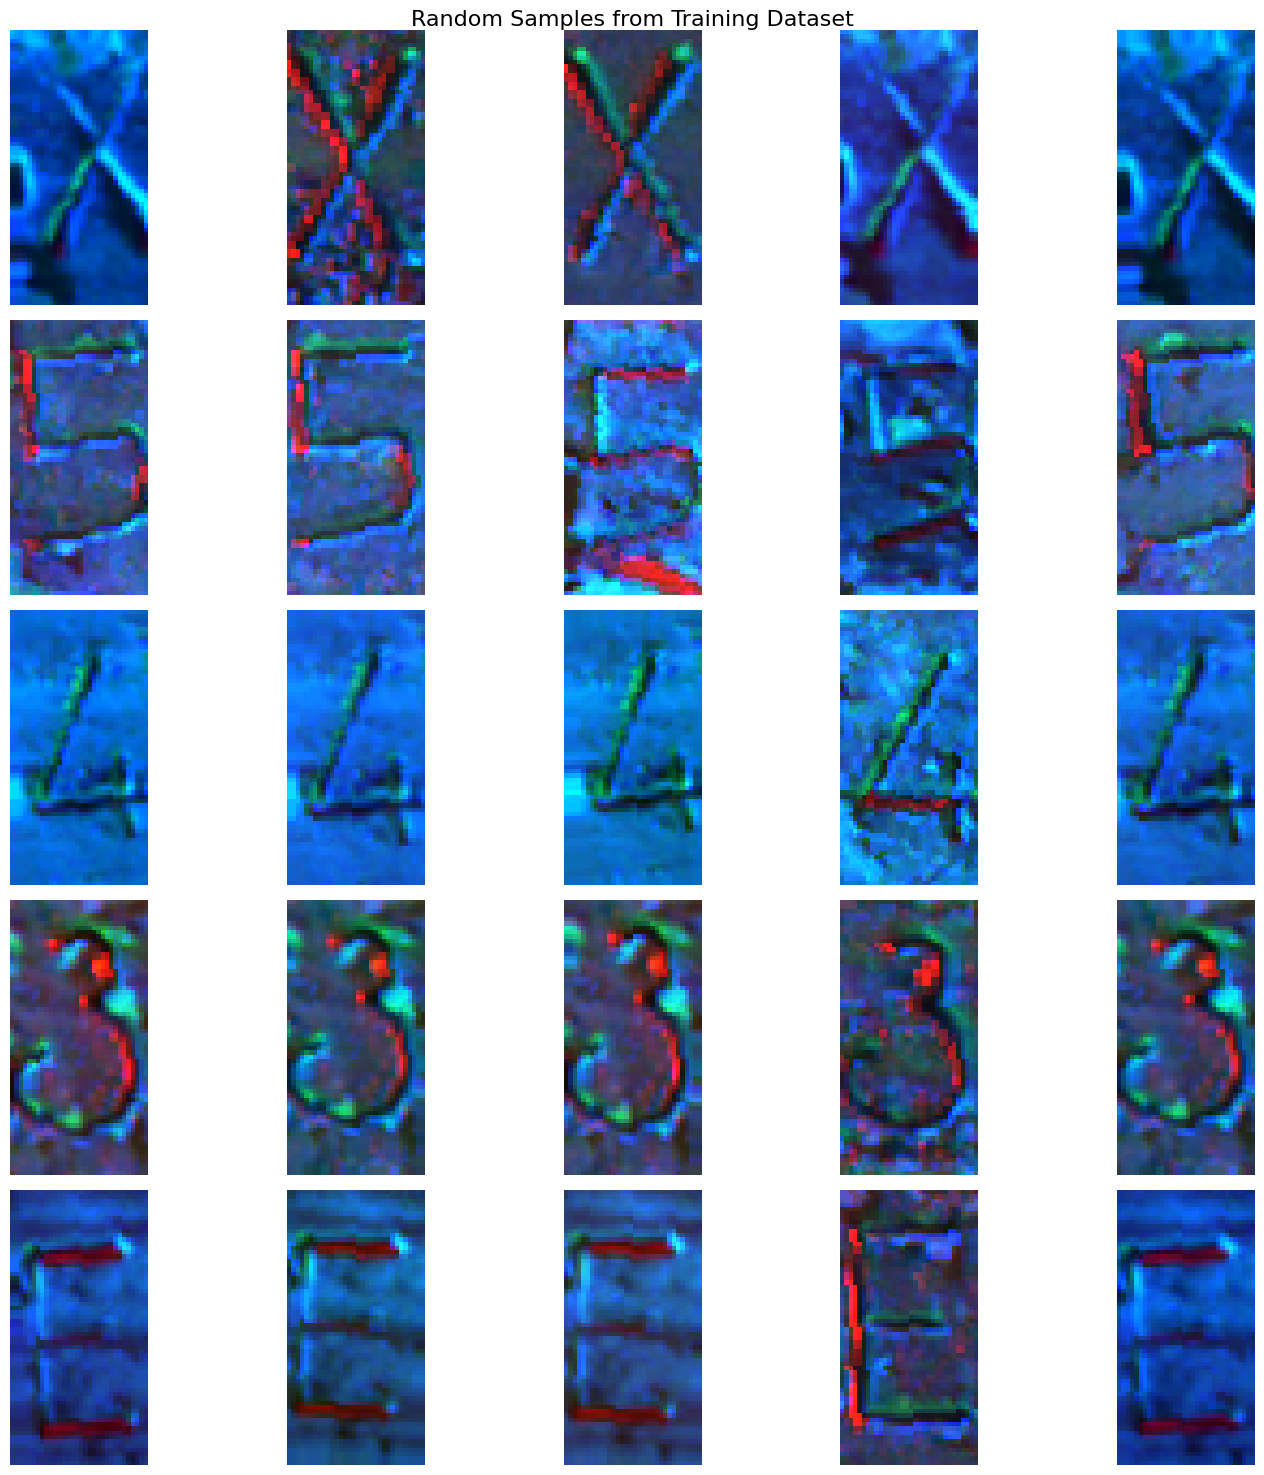

In [3]:
import matplotlib.pyplot as plt
import os
import random
from keras.preprocessing.image import load_img, img_to_array

# Paths to the train folder
train_folder = './Categorized_Character_images/train'

# Function to visualize random samples
def visualize_random_samples(folder, num_classes=5, num_images_per_class=5, img_size=(64, 32)):
    """
    Display random images from the dataset for a subset of classes.
    
    Parameters:
        folder (str): Path to the folder containing class subdirectories.
        num_classes (int): Number of classes to sample.
        num_images_per_class (int): Number of images per class to display.
        img_size (tuple): Target size for loading images.
    """
    classes = sorted(os.listdir(folder))
    sampled_classes = random.sample(classes, min(num_classes, len(classes)))

    plt.figure(figsize=(15, num_classes * 3))
    for i, class_label in enumerate(sampled_classes):
        class_folder = os.path.join(folder, class_label)
        if not os.path.isdir(class_folder):
            continue
        
        image_files = os.listdir(class_folder)
        sampled_images = random.sample(image_files, min(num_images_per_class, len(image_files)))
        
        for j, img_file in enumerate(sampled_images):
            img_path = os.path.join(class_folder, img_file)
            img = load_img(img_path, target_size=img_size)
            plt.subplot(num_classes, num_images_per_class, i * num_images_per_class + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.ylabel(class_label, fontsize=14)
    
    plt.suptitle('Random Samples from Training Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_random_samples(train_folder, num_classes=5, num_images_per_class=5)

The background consistently features a mix of red and blue, while the digits are often slightly off-center, inconsistently scaled, and occasionally tilted. Based on these observations, we will apply the following data augmentations:
1.	Color Channel Variations: To introduce variability in the red and blue channels of the background.
2.  Vertical and Horizontal Shifting: To account for digits not being perfectly centered.
3.	Zooming In and Out: To address variations in digit scaling.
4.	Rotation: To simulate slight tilts in the orientation of the digits.
5.  Blur: To simulate the different material texture.


## 2.  **Data Augmentation** 



Initially, we considered using Keras’s online data augmentation feature (ImageDataGenerator), which dynamically applies augmentations during model training. This method avoids the need to store augmented images in memory, streamlining the process. However, due to inexplicable results during experimentation, we opted to save the augmented data instead. This approach allows us to clearly and easily review and verify the quality of the augmented dataset to ensure its effectiveness.

The detailed data augmentation process is outlined below:

In [4]:
def color_shift_and_blur(image):
    """Applies a random shift to the red and blue channels and a random Gaussian blur."""
    # Color shift
    red_shift = np.random.uniform(-30, 30)  
    blue_shift = np.random.uniform(-30, 30)  
    image[..., 0] = np.clip(image[..., 0] + red_shift, 0, 255)  # Adjust red channel
    image[..., 2] = np.clip(image[..., 2] + blue_shift, 0, 255)  # Adjust blue channel
    
    # Gaussian blur
    if np.random.rand() < 0.05:
        kernel_size = np.random.choice([1, 3])
        image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)  # Apply blur
    
    return image

datagen = ImageDataGenerator(
    rotation_range=5,              # Random rotation (degrees)
    width_shift_range=0.0075,       # Horizontal translation (fraction of total width)
    height_shift_range=0.0075,      # Vertical translation (fraction of total height)
    shear_range=0.2,                # Shear intensity (shear angle in counter-clockwise direction in degrees)
    zoom_range=0.075,                # Random zoom
    horizontal_flip=False,     
    fill_mode='nearest',            # Fill pixels after transformation
    preprocessing_function=color_shift_and_blur
)

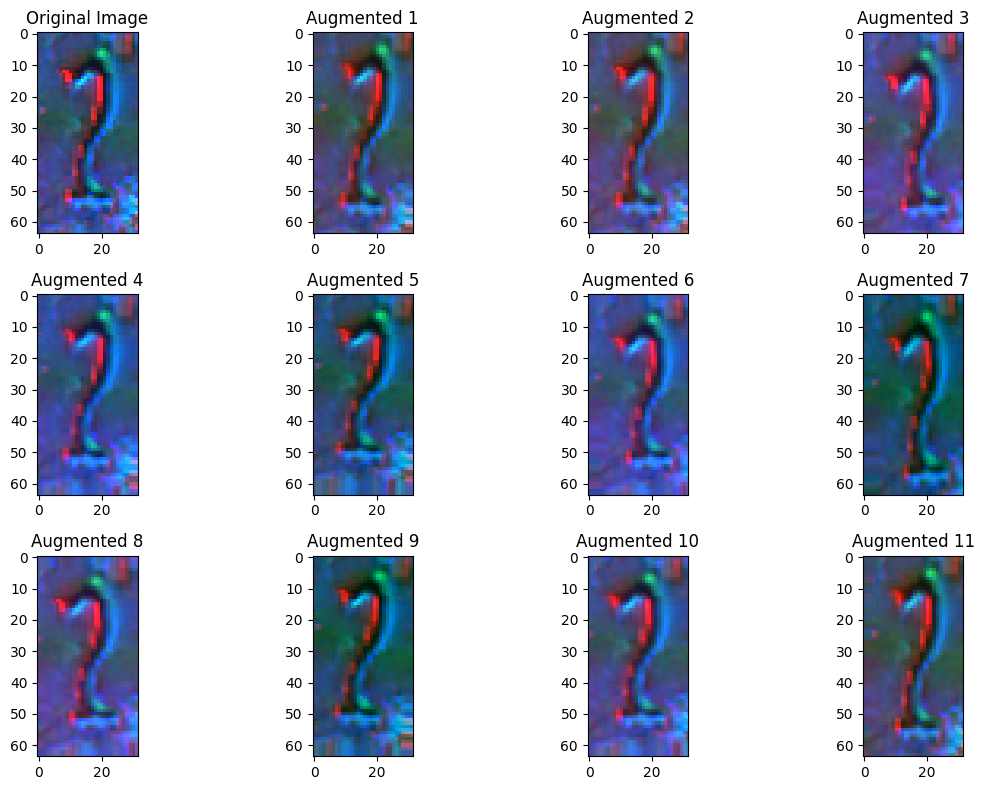

In [5]:
image_path = './Character_Images/sample_04152.png'

# Load the sample image
img = load_img(image_path, target_size=(64, 32)) 
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  

plt.figure(figsize=(12, 8))
plt.subplot(3, 4, 1)
plt.imshow(img_array[0].astype('uint8')) 
plt.title("Original Image")

# Apply standard augmentations and custom color shift
for i, batch in enumerate(datagen.flow(img_array, batch_size=1)):
    if i >= 11:  # Generate only 11 augmented images
        break
    augmented_image = batch[0].astype('uint8') 
    plt.subplot(3, 4, i + 2)
    plt.imshow(augmented_image)
    plt.title(f"Augmented {i+1}")

plt.tight_layout()
plt.show()

In [6]:
# Paths
augmented_folder = './Augmented_Character_Images'  # Backup folder for augmented images (optional)
os.makedirs(augmented_folder, exist_ok=True)

# Function to augment images
def augment_class_images(class_folder, class_label, num_augmentations):
    images = os.listdir(class_folder)
    print(f"Augmenting class '{class_label}' with {num_augmentations} additional images...")
    augmented_count = 0  # Track how many images we've added

    while augmented_count < num_augmentations:
        for img_name in images:
            img_path = os.path.join(class_folder, img_name)
            img = load_img(img_path, target_size=(64, 32))  # Resize for consistency
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)

            # Generate augmented images
            for batch in datagen.flow(img_array, batch_size=1):
                augmented_filename = f"{os.path.splitext(img_name)[0]}_aug_{augmented_count}.png"
                save_path = os.path.join(class_folder, augmented_filename)

                # Save augmented image
                save_img(save_path, batch[0])

                # Optional: Save a backup
                os.makedirs(os.path.join(augmented_folder, class_label), exist_ok=True)
                backup_path = os.path.join(augmented_folder, class_label, augmented_filename)
                save_img(backup_path, batch[0])

                augmented_count += 1
                if augmented_count >= num_augmentations:
                    break

            if augmented_count >= num_augmentations:
                break

# Analyze class distribution
class_distribution = {
    class_label: len(os.listdir(os.path.join(train_folder, class_label)))
    for class_label in os.listdir(train_folder)
}
print(class_distribution)
max_class_count = max(class_distribution.values())
print(max_class_count)
# Augment images for all classes
augmentation_factor = 0.75  # Increase dataset size to 1.5x the largest class
target_count = int(max_class_count * augmentation_factor)

for class_label, class_count in class_distribution.items():
    class_folder = os.path.join(train_folder, class_label)
    num_augmentations = target_count - class_count
    if num_augmentations > 0:
        augment_class_images(class_folder, class_label, num_augmentations)

print("Dataset augmentation completed!")

{'9': 7509, '0': 7684, '7': 7509, '6': 7509, '1': 7509, '8': 7509, 'C': 7509, '4': 7509, 'X': 7509, '3': 7509, 'E': 7509, '2': 7509, '5': 15018}
15018
Augmenting class '9' with 3754 additional images...
Augmenting class '0' with 3579 additional images...
Augmenting class '7' with 3754 additional images...
Augmenting class '6' with 3754 additional images...
Augmenting class '1' with 3754 additional images...
Augmenting class '8' with 3754 additional images...
Augmenting class 'C' with 3754 additional images...
Augmenting class '4' with 3754 additional images...
Augmenting class 'X' with 3754 additional images...
Augmenting class '3' with 3754 additional images...
Augmenting class 'E' with 3754 additional images...
Augmenting class '2' with 3754 additional images...
Dataset augmentation completed!


As shown above, we chose to augment the underrepresented digits to ensure that each class had at least 50% of the samples of the most represented digit. This approach helped address class imbalance effectively, resulting in improved model accuracy and more reliable predictions across all classes.

## 3.  **Model Definition** 


LeNet is a classic convolutional neural network (CNN) architecture designed specifically for character recognition tasks, making it a perfect fit for this project. It is computationally efficient, well-suited for smaller datasets, and requires fewer resources compared to deeper networks like AlexNet. LeNet’s simplicity and proven performance on similar OCR tasks ensure that it effectively captures key features of digits or characters while avoiding overfitting on a limited dataset. Additionally, it can handle 64x32 images with minimal modification, making it ideal for this project.

For more info about Lenet : https://en.wikipedia.org/wiki/LeNet

In [11]:
from Create_model import (
    create_simple_lenet,
    create_augmented_lenet1,
    create_augmented_lenet2,
    create_custom_Lenet_model,
    create_alexnet,
    create_adapted_alexnet,
    cnn_rnn_model,
    multi_scale_cnn,
    depthwise_cnn
)
from tensorflow.keras.optimizers import Adam

# Model creation and compilation
def compile_and_print_summary(model_fn, model_name):
    print(f"{model_name} was successfully created and compiled !")
    model = model_fn()
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Compile and summarize all models
lenet_model_basic = compile_and_print_summary(create_simple_lenet, "LeNet Basic Model")
augmented_lenet1 = compile_and_print_summary(create_augmented_lenet1, "Augmented LeNet Model 1")
augmented_lenet2 = compile_and_print_summary(create_augmented_lenet2, "Augmented LeNet Model 2")
custom_Lenet_model = compile_and_print_summary(create_custom_Lenet_model, "Custom LeNet Model")
alexnet_model = compile_and_print_summary(create_alexnet, "AlexNet Model")
adapted_alexnet_model = compile_and_print_summary(create_adapted_alexnet, "Adapted AlexNet Model")
cnn_rnn_model_1 = compile_and_print_summary(cnn_rnn_model, "CNN-RNN Model")
multi_scale_cnn_1 = compile_and_print_summary(multi_scale_cnn, "Multi-Scale CNN Model")
depthwise_cnn_1 = compile_and_print_summary(depthwise_cnn, "Depthwise CNN Model")

LeNet Basic Model was successfully created and compiled !
Augmented LeNet Model 1 was successfully created and compiled !
Augmented LeNet Model 2 was successfully created and compiled !
Custom LeNet Model was successfully created and compiled !
AlexNet Model was successfully created and compiled !
Adapted AlexNet Model was successfully created and compiled !
CNN-RNN Model was successfully created and compiled !
Multi-Scale CNN Model was successfully created and compiled !
Depthwise CNN Model was successfully created and compiled !


## 4.  **Model Training** 


In [12]:
train_datagen = datagen
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(32, 64),
    batch_size=64,
    class_mode='categorical' 
)

val_generator = test_datagen.flow_from_directory(
    val_folder,
    target_size=(32, 64),
    batch_size=64,
    class_mode='categorical',
    shuffle=False 
)

Found 137935 images belonging to 13 classes.
Found 14993 images belonging to 13 classes.


In [13]:
import time
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def train_and_log_model(model, model_name, train_generator, val_generator, epochs=10, verbose=1):
    """
    Train a model and log its training details with enhanced logging and error handling.
    
    Parameters:
        model: The compiled Keras model to train.
        model_name: Name of the model (string) for logging purposes.
        train_generator: Training data generator.
        val_generator: Validation data generator.
        epochs: Number of epochs to train (default is 10).
        verbose: Verbosity level for model.fit (default is 1).
        
    Returns:
        history: Training history of the model or None if training fails.
    """
    print("=" * 100)
    print(f"Training {model_name} started at {time.strftime('%Y-%m-%d %H:%M:%S')}...")
    print("=" * 100)
    
    # Define callbacks
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ]
    
    try:
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs,
            steps_per_epoch=len(train_generator),
            validation_steps=len(val_generator),
            callbacks=callbacks,
            verbose=verbose
        )
        print(f"Training for {model_name} completed successfully!")
        return history
    except Exception as e:
        print(f"Error occurred while training {model_name}: {e}")
        return None
    finally:
        print("=" * 100)
        print(f"Finished training {model_name} at {time.strftime('%Y-%m-%d %H:%M:%S')}!\n")

# Train models
histories = {}  # Dictionary to store histories for later comparison

models_to_train = {
    'LeNet Basic': (lenet_model_basic, 10),
    'Augmented LeNet 1': (augmented_lenet1, 15),
    'Augmented LeNet 2': (augmented_lenet2, 15),
    'AlexNet': (alexnet_model, 20),
    'Adapted AlexNet': (adapted_alexnet_model, 20),
    'CNN-RNN': (cnn_rnn_model_1, 25),
    'Depthwise CNN': (depthwise_cnn_1, 20),
    'Custom LeNet': (custom_Lenet_model, 10),
}

for model_name, (model, epochs) in models_to_train.items():
    histories[model_name] = train_and_log_model(model, model_name, train_generator, val_generator, epochs=epochs)

Training LeNet Basic started at 2024-12-07 23:33:57...
Epoch 1/10
2156/2156 [==============================] - 91s 42ms/step - loss: 0.1311 - accuracy: 0.9644 - val_loss: 0.0767 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 2/10
2156/2156 [==============================] - 89s 41ms/step - loss: 0.0447 - accuracy: 0.9870 - val_loss: 0.0565 - val_accuracy: 0.9839 - lr: 0.0010
Epoch 3/10
2156/2156 [==============================] - 88s 41ms/step - loss: 0.0369 - accuracy: 0.9893 - val_loss: 0.0483 - val_accuracy: 0.9861 - lr: 0.0010
Epoch 4/10
2156/2156 [==============================] - 84s 39ms/step - loss: 0.0346 - accuracy: 0.9897 - val_loss: 0.0535 - val_accuracy: 0.9857 - lr: 0.0010
Epoch 5/10
2156/2156 [==============================] - 84s 39ms/step - loss: 0.0345 - accuracy: 0.9897 - val_loss: 0.0549 - val_accuracy: 0.9851 - lr: 0.0010
Epoch 6/10
2156/2156 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9898
Epoch 6: ReduceLROnPlateau reducing learning rate to

In [14]:
# Save all trained models with consistent naming
lenet_model_basic.save('./models/LeNet.keras')
augmented_lenet1.save('./models/Augmented_LeNet1.keras')
augmented_lenet2.save('./models/Augmented_LeNet2.keras')
alexnet_model.save('./models/AlexNet.keras')
adapted_alexnet_model.save('./models/Adapted_AlexNet.keras')
cnn_rnn_model_1.save('./models/CNN_RNN.keras')
depthwise_cnn_1.save('./models/Depthwise_CNN.keras')
custom_Lenet_model.save('./models/Custom_LeNet.keras')

print("All models have been saved successfully!")

All models have been saved successfully!


## 5.  **Model Performance** 


In [ ]:
import os
import numpy as np
import time
import pandas as pd
from tensorflow.keras.models import load_model
def evaluate_model(model, val_generator, batch_size=32):
    """
    Evaluate a Keras model for size, inference time, and accuracy.

    Parameters:
        model (tf.keras.Model): The model to evaluate.
        val_generator (tf.keras.utils.Sequence): Validation data generator.
        batch_size (int): Batch size for inference.

    Returns:
        dict: A dictionary with model size, inference time, and accuracy.
    """
    import os
    import time

    # Model size
    model.save("temp_model.h5")
    model_size = os.path.getsize("temp_model.h5") / (1024 * 1024)  # Size in MB
    os.remove("temp_model.h5")

    # Prepare sample data for inference timing
    test_data, _ = next(iter(val_generator))
    if test_data.shape[1:] != model.input_shape[1:]:
        test_data = test_data.transpose((0, 2, 1, 3))  # Adjust shape to match the model's input

    # Inference time
    start_time = time.time()
    for _ in range(10):  # Run inference multiple times for better timing
        _ = model.predict(test_data, batch_size=batch_size, verbose=0)
    end_time = time.time()
    inference_time = (end_time - start_time) / 10  # Average time per inference

    # Accuracy
    loss, accuracy = model.evaluate(val_generator, verbose=0)

    return {
        "Size (MB)": model_size,
        "Inference Time (s)": inference_time,
        "Accuracy": accuracy,
    }

# Define models and names
models = {
    "LeNet Basic": lenet_model_basic,
    "Augmented LeNet 1": augmented_lenet1,
    "Augmented LeNet 2": augmented_lenet2,
    "AlexNet": alexnet_model,
    "Adapted AlexNet": adapted_alexnet_model,
    "CNN-RNN": cnn_rnn_model_1,
    "Depthwise CNN": depthwise_cnn_1,
    "Custom LeNet": custom_Lenet_model,
}

# Evaluate models and store results
results = []
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    metrics = evaluate_model(model, val_generator)
    metrics["Model"] = model_name
    results.append(metrics)



Evaluating LeNet Basic...


/Users/paulrichard/miniconda3/envs/STGCN/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluating Augmented LeNet 1...
Evaluating Augmented LeNet 2...
Evaluating AlexNet...
Evaluating Adapted AlexNet...
Evaluating CNN-RNN...
Evaluating Depthwise CNN...
Evaluating Custom LeNet...


In [33]:
# Create a DataFrame for better visualization
results_df = pd.DataFrame(results)

sorted_results_accuracy_df = results_df.sort_values(by='Accuracy', ascending=False)
results_df = sorted_results_accuracy_df.round({'Size (MB)': 2, 'Inference Time (s)': 3, 'Accuracy': 4})
results_df = results_df[['Model', 'Size (MB)', 'Inference Time (s)', 'Accuracy']]

results_df

,Model,Size (MB),Inference Time (s),Accuracy
3,AlexNet,619.76,0.249,0.9987
2,Augmented LeNet 2,13.60,0.037,0.9984
4,Adapted AlexNet,35.65,0.056,0.9971
7,Custom LeNet,2.07,0.026,0.9953
1,Augmented LeNet 1,0.56,0.027,0.9942
5,CNN-RNN,1.92,0.040,0.9935
0,LeNet Basic,2.06,0.030,0.9917
6,Depthwise CNN,3.07,0.027,0.9917


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Define models
models_to_retrain = {
    "Augmented LeNet 2": create_augmented_lenet2(),
    "Adapted AlexNet": create_adapted_alexnet(),
    "Custom LeNet": create_custom_Lenet_model(),
}

# Compile models with lower learning rate
for name, model in models_to_retrain.items():
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print(f"{name} compiled successfully.")
    
os.makedirs('./models/back-up-training', exist_ok=True)

# Define callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='./models/back-up training/best_model_{epoch:02d}_{val_accuracy:.4f}.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train each model
retraining_history = {}
for name, model in models_to_retrain.items():
    print(f"Retraining {name}...")
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        steps_per_epoch=len(train_generator),
        validation_steps=len(val_generator),
        callbacks=callbacks,
        verbose=1
    )
    retraining_history[name] = history
    print(f"{name} retrained successfully.\n")

    # Save models
for name, model in models_to_retrain.items():
    model.save(f"./retrained_{name.replace(' ', '_')}.keras")
    print(f"{name} saved successfully.")

Augmented LeNet 1 compiled successfully.
Augmented LeNet 2 compiled successfully.
Adapted AlexNet compiled successfully.
Custom LeNet compiled successfully.
Retraining Augmented LeNet 1...
Epoch 1/50
 541/2156 [======>.......................] - ETA: 1:08 - loss: 40.0725 - accuracy: 0.1095

KeyboardInterrupt: 

In [ ]:
results = []
for name, model in models_to_retrain.items():
    loss, accuracy = model.evaluate(val_generator, verbose=0)
    results.append({'Model': name, 'Loss': loss, 'Accuracy': accuracy})

results_df = pd.DataFrame(results)


In [ ]:
results_df

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array

def evaluate_and_visualize_model(model_path, history, train_generator, val_generator, val_folder):
    """
    Evaluates the model, visualizes training history, generates classification reports,
    and plots a confusion matrix and misclassified images.

    Parameters:
        model_path (str): Path to the saved model.
        history: Training history object from model.fit().
        train_generator: Training data generator.
        val_generator: Validation data generator.
        val_folder (str): Path to the validation dataset folder.
    """
    # Load the model
    print("\n### Loading Model ###")
    model = load_model(model_path)

    # Section 1: Plot Training and Validation Metrics
    print("\n### Training and Validation Metrics ###")
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy', fontsize=16)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss', fontsize=16)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Section 2: Evaluate Model on Training and Validation Data
    print("\n### Evaluation Metrics ###")
    test_loss, test_accuracy = model.evaluate(val_generator, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")

    # Section 3: Classification Report and Confusion Matrix
    print("\n### Classification Report and Confusion Matrix ###")
    validation_steps = np.ceil(val_generator.samples / val_generator.batch_size).astype(int)
    validation_predictions = model.predict(val_generator, steps=validation_steps, verbose=1)
    validation_true_classes = np.array(val_generator.classes)[:len(validation_predictions)]
    validation_predicted_classes = np.argmax(validation_predictions, axis=1)

    # Classification report
    class_labels = list(val_generator.class_indices.keys())
    print("Classification Report:")
    print(classification_report(validation_true_classes, validation_predicted_classes, target_names=class_labels))

    # Confusion matrix
    conf_matrix = confusion_matrix(validation_true_classes, validation_predicted_classes)
    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

    # Section 4: Display Misclassified Images
    print("\n### Misclassified Images ###")
    misclassified_indices = np.where(validation_true_classes != validation_predicted_classes)[0]
    num_to_display = min(len(misclassified_indices), 10)

    plt.figure(figsize=(20, 10))
    for i, index in enumerate(misclassified_indices[:num_to_display]):
        img_path = os.path.join(val_folder, val_generator.filenames[index])
        true_label = class_labels[validation_true_classes[index]]
        predicted_label = class_labels[validation_predicted_classes[index]]

        img = load_img(img_path, target_size=(64, 32))
        img_array = img_to_array(img)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img_array.astype('uint8'))
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Misclassified Images", fontsize=16)
    plt.show()

In [ ]:
evaluate_and_visualize_model(
    model_path='Lenet2.h5',
    history=history_basic,
    train_generator=train_generator,
    val_generator=val_generator,
    val_folder=val_folder
)

# 8. Model Summury

In [ ]:
print("\n" + "="*30 + "\nLeNet Basic Model\n" + "="*30)
lenet_model_basic.summary()

print("\n" + "="*30 + "\nAugmented LeNet Model 1\n" + "="*30)
augmented_lenet1.summary()

print("\n" + "="*30 + "\nAugmented LeNet Model 2\n" + "="*30)
augmented_lenet2.summary()

print("\n" + "="*30 + "\nCustom LeNet Model\n" + "="*30)
custom_Lenet_model.summary()

print("\n" + "="*30 + "\nAlexNet Model\n" + "="*30)
alexnet_model.summary()

print("\n" + "="*30 + "\nAdapted AlexNet Model\n" + "="*30)
adapted_alexnet_model.summary()

print("\n" + "="*30 + "\nCNN-RNN Model\n" + "="*30)
cnn_rnn_model_1.summary()

print("\n" + "="*30 + "\nMulti-Scale CNN Model\n" + "="*30)
multi_scale_cnn_1.summary()

print("\n" + "="*30 + "\nDepthwise CNN Model\n" + "="*30)
depthwise_cnn_1.summary()